In [22]:
import numpy as np
import random
import json
import math


class HalfSpinRBM():
    '''
    use +1/-1 to encode the spin-1/2 up/down state
    and take the convention: +1(up): [1,0] & -1(down): [0,1]
    '''
    def __init__(self, visible_num, hidden_num, order):
        # 'order' is used to control the magnitude of the RBM parameters
        self.v_num, self.h_num = visible_num, hidden_num
        self.bias_a = self._random_complex(visible_num, order)
        self.bias_b = self._random_complex(hidden_num, order)
        self.weight_w = self._random_complex((hidden_num,visible_num), order)
        self.state = np.random.choice([1,-1], visible_num)
        
        self.template = list(range(visible_num)) # site index: [0, 1, ..., visible_num-1]
        
        
    def set_parameters(self, bias_a='', bias_b='', weight_w=''):
        if bias_a != '':
            if np.shape(bias_a) == (self.v_num,):
                self.bias_a = bias_a.copy()
            else:
                print('Size not matched, check the size of bias a.')
        if bias_b != '':
            if np.shape(bias_b) == (self.h_num,):
                self.bias_b = bias_b.copy()
            else:
                print('Size not matched, check the size of bias b.')
        if weight_w != '':
            if np.shape(weight_w) == (self.h_num, self.v_num):
                self.weight_w = weight_w.copy()
            else:
                print('Size not matched, check the size of weight w.')
                
                
    def set_state(self, state=''):
        if state != '':
            if np.shape(state) == (self.v_num,):
                self.state = state.copy()
            else:
                print('Size not matched, check the size of the configuration provided.')
                
                
    def measure(self, operator, markov_eq_step=1000, sample_num=2000):
        # calculate <\phi|operator|\phi> / <\phi|\phi>
        for i in range(markov_eq_step):
            self._sampling_once()
        list_op_loc = []
        for i in range(sample_num):
            self._sampling_once()
            list_op_loc.append(self._local_observable(operator, self.state))
        return np.mean(list_op_loc)
    
    
    def SR(self, hamiltonian, learning_rate=0.1, decay_rate=1, regular_weight=1e-2, adapted_weight=False, markov_eq_step=1000, 
           sample_num=2000, epoch=1, obs='', filename='', debug_mode=False):
        # Stochastic Reconfiguration method for imaginary-time evolution
        if obs != '':
            obs_flag = 1
        else:
            obs_flag = 0
            
        if filename == '':
            filename = 'output.json'
            
        data_all = {"iteration": [], "energy": {"real": [], "imag": []}}
        if obs_flag == 1:
            for key in obs.keys():
                data_all[key] = {"real": [], "imag": []}
        
        for epo in range(epoch):
            for i in range(markov_eq_step): # reach the equilibrium stage
                self._sampling_once()
                
            # observables
            data_all["iteration"].append(epo)
            if obs_flag == 1:
                for key in obs.keys():
                    result = self.measure(obs[key], markov_eq_step=0, sample_num=sample_num)
                    data_all[key]["real"].append(result.real)
                    data_all[key]["imag"].append(result.imag)
            
            # SR process
            list_H_loc = []
            rank = self.v_num + self.h_num + self.v_num*self.h_num
            dkdk = np.zeros((rank,rank), dtype=np.complex_) # for <\Delta_{k}\Delta_{k'}>
            dk = np.zeros(rank, dtype=np.complex_) # for <\Delta_{k}>
            dkH = np.zeros(rank, dtype=np.complex_) # for <\Delta_{k}H>
            # order convention: (w, v, h)
            
            for i in range(sample_num):
                for j in range(self.v_num):
                    self._sampling_once()
                list_H_loc.append(self._local_observable(hamiltonian, self.state))
                phi_a = self.state.copy()
                phi_b = np.tanh(self._effective_angles(self.state))
                phi_w = np.outer(phi_b, self.state)
                phi_parameters = np.concatenate((phi_w, phi_a, phi_b), axis=None)
                dkdk += np.outer(phi_parameters, phi_parameters)
                dk += phi_parameters
                dkH += phi_parameters * list_H_loc[-1]
            
            dkdk = dkdk / sample_num
            dk = dk / sample_num
            dkH = dkH / sample_num
            
            # np.real() can be applied, yet we did not
            # Reason: the imaginary part can show the goodness of the sampling
            ave_H = np.mean(list_H_loc) 
            data_all["energy"]["real"].append(ave_H.real)
            data_all["energy"]["imag"].append(ave_H.imag)
            
            matrix_S = dkdk - np.outer(dk, dk) # matrix S is symmetric, how to use this fact in pinv? 
            vector_f = ave_H * dk - dkH
            if adapted_weight == True: 
                # 100*pow(0.9,epo)=1e-2 for epo=87
                # 100*pow(0.9,epo)=1e-1 for epo=65
                regular_coeff = max(100*pow(0.9,epo),regular_weight) 
                # ref: Science 355,6325(2017) doi: 10.1126/science.aag2302
            else:
                regular_coeff = regular_weight
            matrix_invS = np.linalg.pinv(matrix_S+regular_coeff*np.identity(rank)) # regularization
            dev_parameters = np.inner(matrix_invS, vector_f)
            self.weight_w += learning_rate * pow(decay_rate, epo) * np.reshape(
                dev_parameters[0:self.v_num*self.h_num], (self.h_num, self.v_num))
            self.bias_a += learning_rate * pow(decay_rate, epo) * dev_parameters[self.v_num*self.h_num:self.v_num*(self.h_num+1)]
            self.bias_b += learning_rate * pow(decay_rate, epo) * dev_parameters[rank-self.h_num:rank]
            
            ge = ave_H / self.v_num
            print("epoch %s, E/N= %.8f(%.1ej)" %(epo+1, np.real(ge), np.imag(ge)))
            
            # this can help you to adjust the learning rate!
            if debug_mode==True:
                print("weight w: ")
                print(self.weight_w[0])
                print("dw: ")
                print(learning_rate*dev_parameters[self.v_num])
                    
        # save data
        with open(filename, "w") as save_file:
            json.dump(data_all, save_file)
            
            
    def TE(self, hamiltonian, time_step=0.01, markov_eq_step=1000, 
           sample_num=2000, epoch=1, obs='', filename=''):
        # Stochastic Reconfiguration method for real-time evolution
        if obs != '':
            obs_flag = 1
        else:
            obs_flag = 0
            
        if filename == '':
            filename = 'output.json'
            
        data_all = {"time": [], "energy": {"real": [], "imag": []}}
        if obs_flag == 1:
            for key in obs.keys():
                data_all[key] = {"real": [], "imag": []}
        
        for epo in range(epoch):
            for i in range(markov_eq_step): # reach the equilibrium stage
                self._sampling_once()
                
            # observables
            data_all["time"].append(epo*time_step)
            if obs_flag == 1:
                for key in obs.keys():
                    result = self.measure(obs[key], markov_eq_step=0, sample_num=sample_num)
                    data_all[key]["real"].append(result.real)
                    data_all[key]["imag"].append(result.imag)
            
            # SR process
            list_H_loc = []
            rank = self.v_num + self.h_num + self.v_num*self.h_num
            dkdk = np.zeros((rank,rank), dtype=np.complex_) # for <\Delta_{k}\Delta_{k'}>
            dk = np.zeros(rank, dtype=np.complex_) # for <\Delta_{k}>
            dkH = np.zeros(rank, dtype=np.complex_) # for <\Delta_{k}H>
            # order convention: (w, v, h)
            
            for i in range(sample_num):
                self._sampling_once()
                list_H_loc.append(self._local_observable(hamiltonian, self.state))
                phi_a = self.state.copy()
                phi_b = np.tanh(self._effective_angles(self.state))
                phi_w = np.outer(phi_b, self.state)
                phi_parameters = np.concatenate((phi_w, phi_a, phi_b), axis=None)
                dkdk += np.outer(phi_parameters, phi_parameters)
                dk += phi_parameters
                dkH += phi_parameters * list_H_loc[-1]
            
            dkdk = dkdk / sample_num
            dk = dk / sample_num
            dkH = dkH / sample_num
            
            ave_H = np.mean(list_H_loc) # np.real() can be applied, yet we did not
            data_all["energy"]["real"].append(ave_H.real)
            data_all["energy"]["imag"].append(ave_H.imag)
            
            matrix_S = dkdk - np.outer(dk, dk) # matrix S is symmetric, how to use this fact in pinv? 
            vector_f = ave_H * dk - dkH
            matrix_invS = np.linalg.pinv(matrix_S)
            dev_parameters = np.inner(matrix_invS, vector_f)
            self.weight_w += 1.j * time_step * np.reshape(
                dev_parameters[0:self.v_num*self.h_num], (self.h_num, self.v_num))
            self.bias_a += 1.j * time_step * dev_parameters[self.v_num*self.h_num:self.v_num*(self.h_num+1)]
            self.bias_b += 1.j * time_step * dev_parameters[rank-self.h_num:rank]
            
            ge = ave_H / self.v_num
            print("time %s, E/N= %.8f(%.1ej)" %(epo*time_step, np.real(ge), np.imag(ge)))
                    
        # save data
        with open(filename, "w") as save_file:
            json.dump(data_all, save_file)

    
    def _sampling_once(self):
        # perform one markov-chain sampling step
        phi_old = self._wf(self.state)
        site = random.choice(self.template) # choose one site randomly
        self.state[site] *= -1 # spin flip
        phi_new = self._wf(self.state)
        prob = np.real( phi_new*np.conj(phi_new) / (phi_old*np.conj(phi_old)) ) # real number
        if random.uniform(0,1) < prob:
            return 0 # accepted
        else:
            self.state[site] *= -1 # spin flip back
            return 1 # rejected 
        
        
    def _local_observable(self, observable, state):
        # obey Python convention: index begins with 0
        # 'observable' is a list storing the local form of an operator, e.g. Hamiltonian
        # in general, local observable should be a complex number!!!
        # for Hermitian operator, the average over 'state' should be real;
        # for non-Hermitian operator, the average would not be necessarily real!
        # 'observable' example: for 2-site Ising model
        # sx = [[0,1],[1,0]], sz = [[1,0],[0,-1]]
        # [ [[0], -sx], [[1], -sx], [[0,1], -np.kron(sz,sz)] ] is a legal 'observable'
        obs_loc = 0.+0.j
        phi_state = self._wf(state)
        for term in observable:
            pos_list = term[0]
            local_degree = len(pos_list) # how many sites are involved in this term
            operator = term[1]
            config = [state[pos] for pos in pos_list] # configuration of the related sites
            row = self._configuration_index(config) # configuration encoding(index)
            eles = operator[row] # only the 'row'-th row of the operator contributes
            for i in range(len(eles)):
                config_prime = self._index_configuration(i, local_degree)
                state_prime = state.copy()
                for k in range(local_degree):
                    state_prime[pos_list[k]] = config_prime[k]
                phi_state_prime = self._wf(state_prime)
                obs_loc += phi_state_prime * eles[i]
        return obs_loc / phi_state
            
            
    def _configuration_index(self, config):
        # 'config' is a list of +1/-1 storing the local configuration
        # this function gives the index of the configuration in the local Hilbert space
        # e.g. for 3-site local Hilbert sapce, index list = [0, 1, 2, ..., 7] for total 8 configurations
        # [-1,1,1] -> 4; [-1,-1,1] -> 6; [1,-1,1] -> 2; [1,1,1] -> 0; [-1,-1,-1] -> 7
        temp = (1+np.array(config))/2 # +1/-1 convert to +1/0 to use binary (e.g. 10101, 0101, 101, etc)
        temp = ''.join(str(int(1-e)) for e in temp) # exchange 1/0 to meet the convention of spin physics
        return int(temp, 2)
        
        
    def _index_configuration(self, pos, length):
        # the inverse of the function self._configuration_index()
        # 'length' is the site number involved in the local Hilbert space
        temp = bin(pos)[2:].zfill(length)
        config = []
        for ele in temp:
            config.append( int(2*(1-int(ele))-1) )
        return config
        
        
    def _wf(self, state):
        # given one of the spin configurations \vec{\sigma}
        # return the corresponding wave function \phi(\vec{sigma})
        return np.exp(np.inner(self.bias_a, state)) * np.prod(2*np.cosh(self._effective_angles(state)))
        
        
    def _effective_angles(self, state):
        # the effective angle is defined as: b + W*\vec{\sigma}
        return self.bias_b + np.inner(self.weight_w, state)
        
        
    def _random_complex(self, size, order):
        # used to generate a complex number array randomly
        # 'size' can be an integer or a tuple of integers, e.g. 4 or (2,3)
        real_part = (np.random.random(size)-0.5) * pow(10, order)
        imag_part = (np.random.random(size)-0.5) * pow(10, order)
        return real_part+1.j*imag_part

## Basic Tutorial

In [ ]:
# define a HalfSpinRBM class and see its parameters
model = HalfSpinRBM(4,2,-2)
print(model.bias_a)
print(model.bias_b)
print(model.weight_w)
print(model.state)
print(model.template)

In [ ]:
# reset the RBM parameters by hand
model = HalfSpinRBM(4,2,-2)
a = [1,1,1,1]
b = [-1,-1]
w = [[0.5,0.5,0.5,0.5],[-0.5,-0.5,-0.5,-0.5]]
s = [-1,1,-1,1]
model.set_parameters(weight_w=w, bias_b=b, bias_a=a)
model.set_state(s)
print(model.bias_a)
print(model.bias_b)
print(model.weight_w)
print(model.state)

In [ ]:
# generate a randomly sampled complex-valued array
model = HalfSpinRBM(4,2,-2)
print(model._random_complex(4,0))
print(model._random_complex((2,4),0))

In [ ]:
# calculate the wave function (not normalized)
model = HalfSpinRBM(4,2,-2)
a = [1,1,1,1]
b = [-1,-1]
w = [[0.5,0.5,0.5,0.5],[-0.5,-0.5,-0.5,-0.5]]
model.set_parameters(weight_w=w, bias_b=b, bias_a=a)
print(model._wf([1,1,1,1])) # 3392.78
print(model._wf([-1,-1,-1,-1])) # 1.14

In [ ]:
# index function of the spin configurations
model = HalfSpinRBM(4,2,-2)
print(model._configuration_index([-1,1,-1])) # 5
print(model._configuration_index([-1,-1,-1,-1,-1,-1])) # 63
print(model._index_configuration(4,5)) # [1,1,-1,1,1]
print(model._index_configuration(7,3)) # [-1,-1,-1]

In [ ]:
# the calculation of the local observables
model = HalfSpinRBM(3,2,-1)
obs = []
ide = [[1,0],[0,1]]
sx = [[0,1],[1,0]]
sz = [[1,0],[0,-1]]
sy = [[0,-1j],[1j,0]]
szz = np.kron(sz,sz)
syy = np.kron(sy,sy)
sxx = np.kron(sx,sx)
obs.append([[0],sx])
obs.append([[1],sy])
obs.append([[2],sz])
obs.append([[0,1],szz])
obs.append([[1,2],syy])
obs.append([[2,0],sxx])
obs_loc1 = model._local_observable(obs,[1,-1,-1])
# in another way
obs_matrix = np.zeros((8,8), dtype=np.complex_)
obs_matrix += np.kron(sx, np.kron(ide, ide))
obs_matrix += np.kron(ide, np.kron(sy, ide))
obs_matrix += np.kron(ide, np.kron(ide, sz))
obs_matrix += np.kron(szz, ide)
obs_matrix += np.kron(ide, syy)
obs_matrix += np.kron(sx, np.kron(ide, sx))
# wave function (not normalized)
wf = []
for i in range(8):
    wf.append(model._wf(model._index_configuration(i,3)))
wf = np.array(wf)
pos = model._configuration_index([1,-1,-1])
obs_loc2 = np.inner(obs_matrix, wf)[pos] / wf[pos]
# compare
print(obs_loc1)
print(obs_loc2)
print(obs_loc1-obs_loc2)

In [ ]:
# the calculation of the expectation value of an obversable
model = HalfSpinRBM(3,2,-1)
obs = []
ide = [[1,0],[0,1]]
sx = [[0,1],[1,0]]
sz = [[1,0],[0,-1]]
sy = [[0,-1j],[1j,0]]
szz = np.kron(sz,sz)
syy = np.kron(sy,sy)
sxx = np.kron(sx,sx)
obs.append([[0],sx])
obs.append([[1],sy])
obs.append([[2],sz])
obs.append([[0,1],szz])
obs.append([[1,2],syy])
obs.append([[2,0],sxx])
obs_ave1 = model.measure(obs, markov_eq_step=1000, sample_num=10000)
# in another way
obs_matrix = np.zeros((8,8), dtype=np.complex_)
obs_matrix += np.kron(sx, np.kron(ide, ide))
obs_matrix += np.kron(ide, np.kron(sy, ide))
obs_matrix += np.kron(ide, np.kron(ide, sz))
obs_matrix += np.kron(szz, ide)
obs_matrix += np.kron(ide, syy)
obs_matrix += np.kron(sx, np.kron(ide, sx))
# wave function (normalized)
wf = []
for i in range(8):
    wf.append(model._wf(model._index_configuration(i,3)))
wf = np.array(wf) / np.linalg.norm(wf)
obs_ave2 = np.inner(np.conj(wf), np.inner(obs_matrix, wf))
# compare
print(obs_ave1)
print(obs_ave2)
print(obs_ave1-obs_ave2)

## Ground State Solver

In [ ]:
# a full ground state solver (Ising model)
N = 4
M = 1 * N
h = 0
order = -2
H = []
sx = np.array([[0,1],[1,0]])
sy = np.array([[0,-1j],[1j,0]])
sz = np.array([[1,0],[0,-1]])
for i in range(N):
    H.append([[i],-h*sx])
    H.append([[i,(i+1)%N],-np.kron(sz,sz)])
model = HalfSpinRBM(N,M,order)
model.SR(hamiltonian=H, learning_rate=0.05, regular_weight=1e-2, markov_eq_step=400, sample_num=800, epoch=50)

In [ ]:
# a full ground state solver (Heisenberg model)
N = 3
M = 2 * N
order = -2
H = []
sx = np.array([[0,1],[1,0]])
sy = np.array([[0,-1j],[1j,0]])
sz = np.array([[1,0],[0,-1]])
for i in range(N):
    H.append([[i,(i+1)%N],np.kron(sx,sx)])
    H.append([[i,(i+1)%N],np.kron(sy,sy)])
    H.append([[i,(i+1)%N],np.kron(sz,sz)])
model = HalfSpinRBM(N,M,order)
model.SR(hamiltonian=H, learning_rate=0.1, regular_weight=1e-4, adapted_weight=True, markov_eq_step=400, sample_num=800, epoch=100)

## A Simple Example of Quantum Quench Dynamics

In [ ]:
# time evolution test (Ising model)
N = 2 
M = 2 * N
hi = 0.5
hf = 1.
order = -2
Hi = []
Hf = []
mx = []
sx = np.array([[0,1],[1,0]])
sy = np.array([[0,-1j],[1j,0]])
sz = np.array([[1,0],[0,-1]])
for i in range(N):
    Hi.append([[i],-hi*sx])
    Hf.append([[i],-hf*sx])
    mx.append([[i],sx])
    Hi.append([[i,(i+1)%N],-np.kron(sz,sz)])
    Hf.append([[i,(i+1)%N],-np.kron(sz,sz)])
model = HalfSpinRBM(N,M,order)
model.SR(hamiltonian=Hi, learning_rate=0.1, decay_rate=0.99, regular_weight=1e-8, adapted_weight=True, markov_eq_step=2000, sample_num=10000, epoch=1000)
model.TE(hamiltonian=Hf, time_step=0.001, markov_eq_step=5000, sample_num=10000, obs={"mx": mx}, filename="mx_te2_ising2.json", epoch=2001)

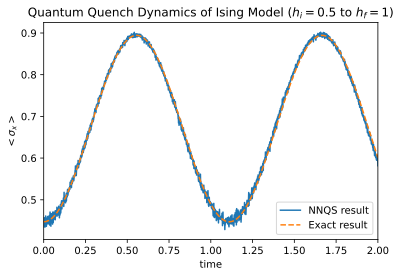

In [23]:
### Compare with the exact solution

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

N = 2

time_list = []
mx_list = []
with open("mx_te2_ising2.json", "r") as mx_file:
    data = json.load(mx_file)
time_list = data["time"]
mx_list = data["mx"]["real"]
mx_list = np.array(mx_list) / N

time_exact = []
mx_exact = []
with open("exact_mx_ising2.json") as exact_file:
    data_exact = json.load(exact_file)
data_exact = np.array(data_exact).T
time_exact = data_exact[0]
mx_exact = data_exact[1]

plt.plot(time_list, mx_list, label="NNQS result")
plt.plot(time_exact, mx_exact, label="Exact result", linestyle="dashed")
plt.legend()
plt.xlim(0,2)
plt.xlabel("time")
plt.ylabel("$<\sigma_x>$")
plt.title("Quantum Quench Dynamics of Ising Model ($h_i=0.5$ to $h_f=1$)")
plt.show()